# Monte Carlo Simulation

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import sdm

# Define model

In [2]:
# define adjacency matrix
matrix = np.array([
    [0,1,1,0,1,1,0,0],
    [1,0,1,0,1,1,1,0],
    [1,1,0,1,1,0,0,0],
    [0,0,1,0,0,0,1,0],
    [1,1,1,0,0,0,0,0],
    [1,1,0,0,0,0,1,0],
    [0,1,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0],
])

In [3]:
# define parameters of filter dgp
process = "static"

# works
if process == "static":
    params_filter = {
        "vOmega": np.array([0.05, 0.08])
    }
# does not work
elif process == "step":
    params_filter = {
        "vOmega1": np.array([0.8, 0.5]),
        "vOmega2": np.array([0.5, 0.8])
    }
# kind of works?
elif process == "ramp":
    params_filter = {
        "vBreakpoint": np.array([3, 2]),
        "vBounds": np.array([0.7, 0.9])
    }

In [4]:
# define parameters of observation dgp
params_observation = {
    "vBeta": np.array([1.5]),
    "dSigma2": np.array([2.0])
}

In [5]:
# define time series length
iT = 1000

In [6]:
# infer model size
iN, _ = matrix.shape
iI = 2
iK = len(params_observation["vBeta"])

In [7]:
# define configurations for the spatial gas model
model = sdm.SpatialGasModel("mvnorm", "identity", 0.99)

In [8]:
# simulate covariates
mmX = sdm.covariates.simulate(iT, iN, iK)

In [9]:
# add adjacency matrix and build iT x iN x iN weighting matrix
adjacency_matrix = sdm.AdjacencyMatrix()
adjacency_matrix.add(0, iT, matrix)
mmW = adjacency_matrix.build()

# Monte Carlo Simulation

## Simulate and Estimate

In [10]:
# initialize
iB = 5

# instantiate experiment
monte_carlo = sdm.MonteCarlo(params_observation, params_filter, "dynamic_heterogenous")

for b in range(iB):
    # status
    print(f"Iteration: {b+1}", end="\r")
    # simulate model
    model_sim = model.simulate(mmX, mmW, params_filter, params_observation, process)
    # estimate the model
    model_fit = model.estimate(model_sim.mY, mmX, mmW, iI, "dynamic_heterogenous")
    # store result
    monte_carlo.add(model_fit.params, model_sim.mRho, model_fit.mRho, model_fit.convergence, model_fit.elapsed_time)

/Users/jinhoffen/miniconda3/envs/gasmodel/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/jinhoffen/miniconda3/envs/gasmodel/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/jinhoffen/miniconda3/envs/gasmodel/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/jinhoffen/miniconda3/envs/gasmodel/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


# Result

## Spatial dependence plots

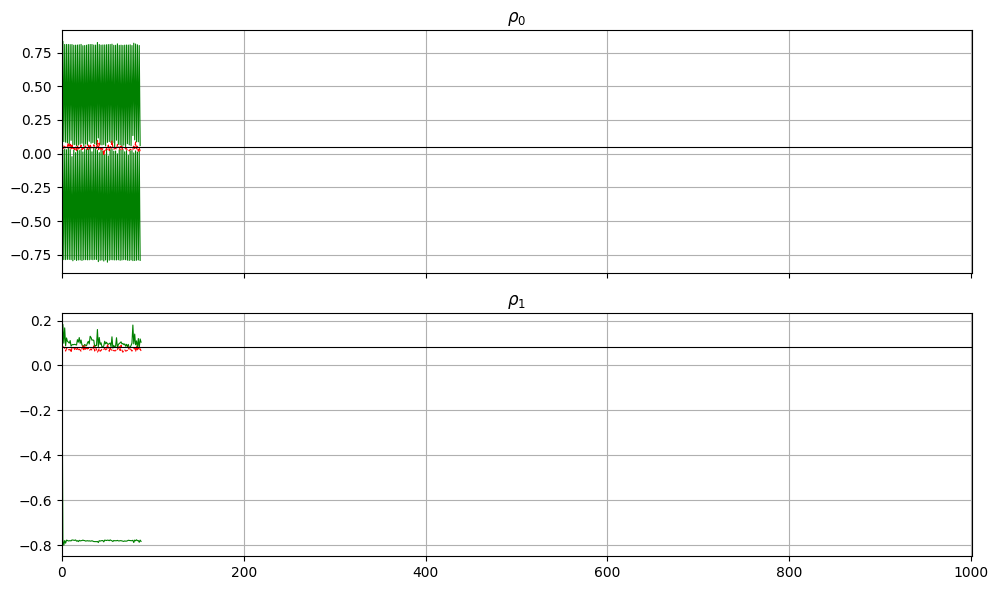

In [11]:
# setting
lb = 0.05
ub = 1-0.05

# compute average of simulated mRho
simulated = np.median(monte_carlo.rho_simulated, axis=0)

# compute quantiles of filtered spatial dependence
estimated_median = np.median(monte_carlo.rho_estimated, axis=0)
estimated_lb = np.quantile(monte_carlo.rho_estimated, lb, axis=0)
estimated_ub = np.quantile(monte_carlo.rho_estimated, ub, axis=0)

# infer model size
iT, iP = simulated.shape
time_periods = np.arange(iT)

# setup plot
fig, axs = plt.subplots(figsize=(10,6), nrows=iP, sharex=True)

# spatial parameter
for i in range(iP):
    axs[i].plot(time_periods, estimated_ub[:iT,i], color="green", linestyle="solid", linewidth=0.8)
    axs[i].plot(time_periods, estimated_lb[:iT,i], color="green", linestyle="solid", linewidth=0.8)
    axs[i].plot(time_periods, estimated_median[:iT,i], color="red", linestyle="dashed", linewidth=0.8)
    axs[i].plot(time_periods, simulated[:iT,i], color="black", linestyle="solid", linewidth=0.8)

# axis
for i in range(iP):
    axs[i].set_title(r"$\rho_{}$".format(i))
    axs[i].grid(True)
    axs[i].set_xlim(0,iT)

fig.tight_layout()

## Density plots

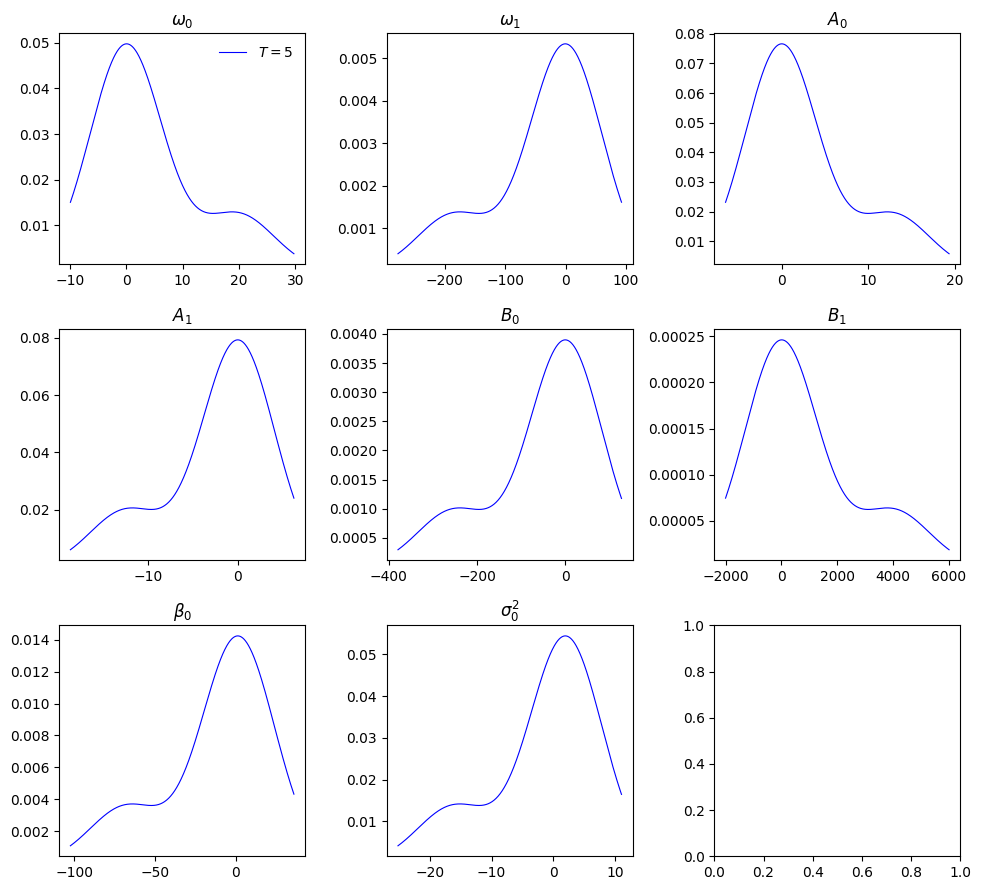

In [12]:
if monte_carlo.nparams % 3 == 0:
    fig, axs = plt.subplots(figsize=(10,9), nrows=int(monte_carlo.nparams / 3), ncols=3)
else:
    fig, axs = plt.subplots(figsize=(10,9), nrows=int(monte_carlo.nparams / 3 + 1), ncols=3)

# get frame
df = monte_carlo.params_est

# plot by parameter
columns = df.columns

for plot_id, ax in enumerate(axs.flatten()[:len(df.columns)]):
    # draw estimates' density and true value
    df.iloc[:,plot_id].plot(
        kind="density",
        ax=ax,
        color="blue",
        linewidth=0.8,
        label=r"$T = {}$".format(monte_carlo.size)
    )
    # hide yaxis label
    ax.yaxis.label.set_visible(False)
    # set title
    param_label, param_id = df.columns[plot_id]
    label = {
        "vOmega": "\\omega",
        "vA": "A",
        "vB": "B",
        "vBeta": "\\beta",
        "dSigma2": "\\sigma^2"
    }
    title = r"${}_{}$".format(label[param_label], param_id)
    ax.set_title(title)

# legend
axs[0,0].legend(frameon=False, loc="upper right")

fig.tight_layout()

plt.show()